In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import random

In [2]:
df2018 = pd.read_excel('WHR2018Chapter2OnlineData.xls', sheet_name='Figure2.2', usecols='A:K', header=0, nrows=156)
df2018.shape

(156, 11)

In [3]:
df2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 11 columns):
Country                                       156 non-null object
Happiness score                               156 non-null float64
Whisker-high                                  156 non-null float64
Whisker-low                                   156 non-null float64
Dystopia (1.92) + residual                    156 non-null float64
Explained by: GDP per capita                  156 non-null float64
Explained by: Social support                  156 non-null float64
Explained by: Healthy life expectancy         156 non-null float64
Explained by: Freedom to make life choices    156 non-null float64
Explained by: Generosity                      156 non-null float64
Explained by: Perceptions of corruption       156 non-null float64
dtypes: float64(10), object(1)
memory usage: 13.5+ KB


In [4]:
old_column_names = list(df2018.columns)
def change_col_name(x):
    if x.startswith('Explained by: '):
        return x[14:] # drop "Explained by"
    else:
        return x
    
new_column_names = [change_col_name(x) for x in old_column_names]
df2018.columns = new_column_names

In [5]:
df2018.columns

Index(['Country', 'Happiness score', 'Whisker-high', 'Whisker-low',
       'Dystopia (1.92) + residual', 'GDP per capita', 'Social support',
       'Healthy life expectancy', 'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption'],
      dtype='object')

In [6]:
df2018_features = df2018.drop(['Whisker-high', 'Whisker-low'], axis=1)
df2018_features.corr()

,Happiness score,Dystopia (1.92) + residual,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
Happiness score,1.000000,0.473657,0.807384,0.764660,0.777542,0.562397,0.141490,0.408406
Dystopia (1.92) + residual,0.473657,1.000000,0.000238,0.042941,-0.002598,0.083243,-0.066530,-0.028739
GDP per capita,0.807384,0.000238,1.000000,0.725095,0.864831,0.363491,-0.005585,0.315322
Social support,0.764660,0.042941,0.725095,1.000000,0.674630,0.405505,0.018847,0.218967
Healthy life expectancy,0.777542,-0.002598,0.864831,0.674630,1.000000,0.356210,0.022929,0.312976
Freedom to make life choices,0.562397,0.083243,0.363491,0.405505,0.356210,1.000000,0.304452,0.465370
Generosity,0.141490,-0.066530,-0.005585,0.018847,0.022929,0.304452,1.000000,0.363306
Perceptions of corruption,0.408406,-0.028739,0.315322,0.218967,0.312976,0.465370,0.363306,1.000000


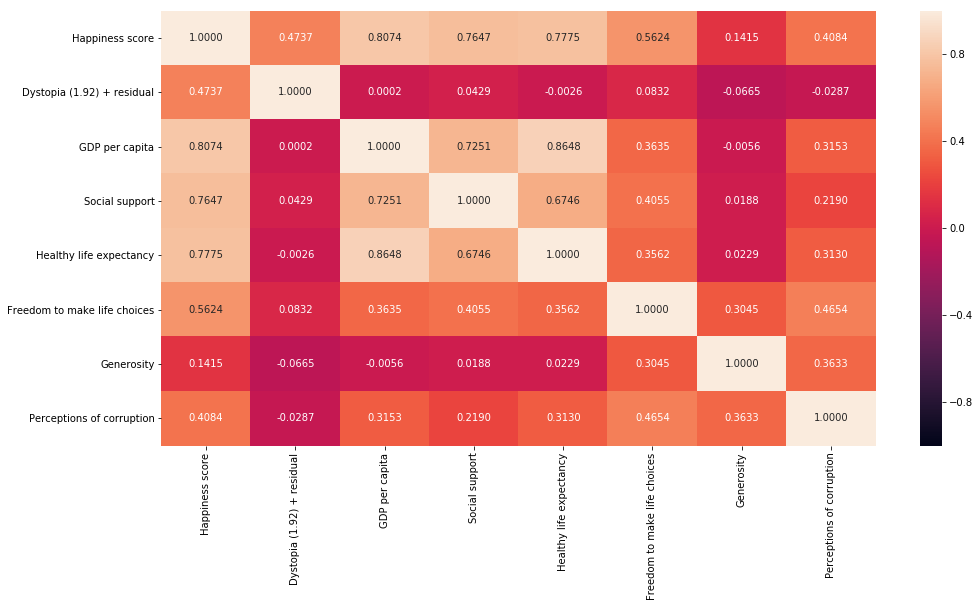

In [7]:
f, ax = plt.subplots(1,1, figsize=(16,8))
sb.heatmap(df2018_features.corr(), vmin = -1, vmax=1, annot=True, fmt='.4f')

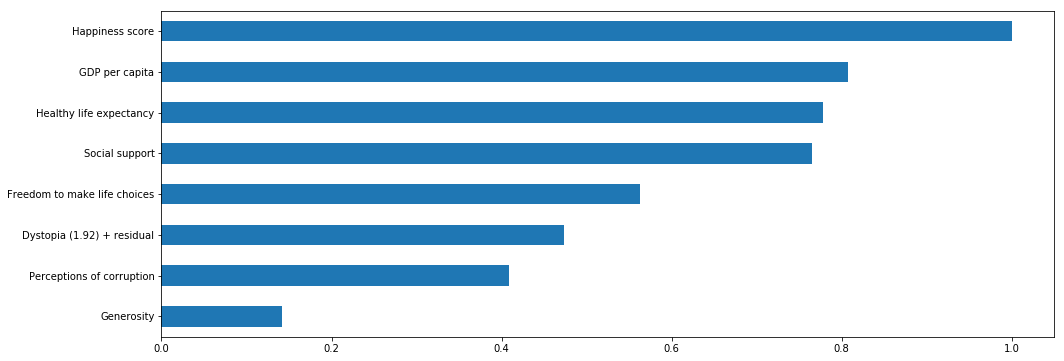

In [8]:
df2018_features.corr().iloc[0,].sort_values().plot.barh(figsize=(16,6))

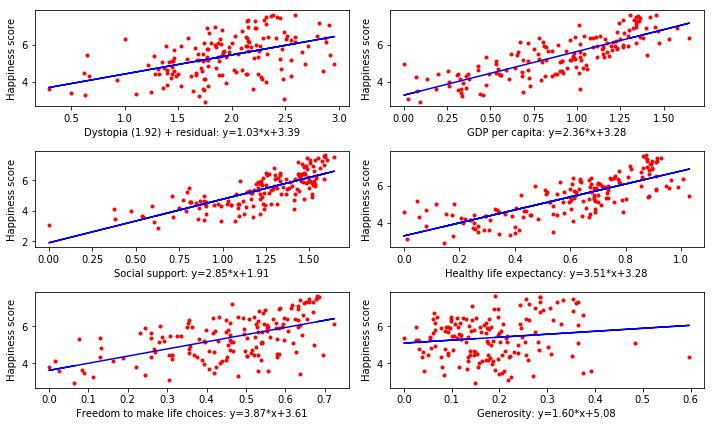

In [9]:
# Relationship between GDP and happiness
from sklearn.linear_model import LinearRegression
i=0
f, axes = plt.subplots(3,2, figsize=(10,6))
for col in df2018.columns[4:10]:
    lrg = LinearRegression()
    lrg.fit(np.array(df2018[col]).reshape(-1,1), df2018['Happiness score'])
    a = lrg.coef_[0]
    b = lrg.intercept_
    y_pred = lrg.predict(np.array(df2018[col]).reshape(-1,1))
    
    plt.subplot(3,2,i+1)
    plt.plot(df2018[col], df2018['Happiness score'], 'r.')
    plt.plot(df2018[col], y_pred, 'b-')
    plt.xlabel('{}: y={:.2f}*x+{:.2f}'.format(col,a,b))
    plt.ylabel('Happiness score')
    i=i+1

plt.tight_layout(True)

In [10]:
# Prepare X_train, X_test, y_train, y_test and 3 regression models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

X = df2018[['GDP per capita', 'Healthy life expectancy', 'Social support']]
y = df2018['Happiness score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [11]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
print("Training set R^2:", linreg.score(X_train, y_train))
print("Test set R^2:", linreg.score(X_test, y_test))

Training set R^2: 0.7424408175542454
Test set R^2: 0.6930472724863388


### Using Ridge regression to train model
We also use GridSearchCV to look for the best parameters giving the best result. In this case, we want to find the optimal alpha of Ridge loss function (l2 loss)

In [12]:
ridge = Ridge()
# Create alpha range
alpha_space = np.linspace(0.5, 1.4, 10)
param_ridge = {'alpha': alpha_space}

# Train with GridSearchCV
ridge_grid = GridSearchCV(ridge, param_ridge)
ridge_grid.fit(X_train, y_train)

# Observe the best alpha
print('Best alpha:', ridge_grid.best_params_)
print('Best R^2:', ridge_grid.best_score_)

Best alpha: {'alpha': 1.2}
Best R^2: 0.7179711303785001


/home/whitebeard4708/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/whitebeard4708/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Here, we create Ridge regression with our best found alpha = 1.2 to train on our model to see how it performs on both sets

In [13]:
ridge = Ridge(alpha=1.2)
ridge.fit(X_train, y_train)
print("Training set R^2:", ridge.score(X_train, y_train))
print("Test set:", ridge.score(X_test, y_test))

Training set R^2: 0.7411096796432359
Test set: 0.6895442091274243


### Using Lasso regression to train model
We also use GridSearchCV to look for the best parameters giving the best result. In this case, we want to find the optimal alpha of Lasso loss function (l1 loss)

In [14]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso = Lasso()
# Create alpha range
alpha_space = np.linspace(1.2, 1.5, 10)
param_lasso = {'alpha': alpha_space}

# Train with GridSearchCV
lasso_grid = GridSearchCV(lasso, param_lasso)
lasso_grid.fit(X_train, y_train)

# Observe the best alpha
print('Best alpha:', lasso_grid.best_params_)

/home/whitebeard4708/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best alpha: {'alpha': 1.2}


/home/whitebeard4708/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [15]:
lasso = Lasso(alpha=1.2)
lasso.fit(X_train, y_train)

Lasso(alpha=1.2, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Let's see how our 3 model performs on a random country

In [16]:
random_index = random.randint(0, 155)
x = X.iloc[random_index: random_index+1,]
print('Country\t\t\t\t{}'.format(df2018.iloc[random_index, 0]))
print('Actual happiness score:\t\t{}'.format(df2018.iloc[random_index, 1]))
print('Happiness score (Linear):\t{}'.format(linreg.predict(x)[0]))
print('Happiness score (Ridge):\t{}'.format(ridge.predict(x)[0]))
print('Happiness score (Lasso):\t{}'.format(lasso.predict(x)[0]))

Country				Ecuador
Actual happiness score:		5.973199844360352
Happiness score (Linear):	5.654921914033796
Happiness score (Ridge):	5.618467733912672
Happiness score (Lasso):	5.3454386957230104


## Training models with more data from previous years

In [17]:
df2017 = pd.read_csv('2017.csv')
df2016 = pd.read_csv('2016.csv')
df2015 = pd.read_csv('2015.csv')

# 2017 data
df2017.columns = df2017.columns.str.replace('(\))|(\()|(\.$)', '')
df2017.columns = df2017.columns.str.replace('\.+', ' ')
# 2016 data
df2016.columns = df2016.columns.str.replace('(\))|(\()|(\.$)', '')
df2016.columns = df2016.columns.str.replace('\.+', ' ')
# 2015 data
df2015.columns = df2015.columns.str.replace('(\))|(\()|(\.$)', '')
df2015.columns = df2015.columns.str.replace('\.+', ' ')

features = ['Happiness Score', 'Economy GDP per Capita', 'Health Life Expectancy', 'Family']
features2017 = df2017[features]
features2016 = df2016[features]
features2015 = df2015[features]
features_total = pd.concat([features2015, features2016, features2017], axis=0)
features_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 470 entries, 0 to 154
Data columns (total 4 columns):
Happiness Score           470 non-null float64
Economy GDP per Capita    470 non-null float64
Health Life Expectancy    470 non-null float64
Family                    470 non-null float64
dtypes: float64(4)
memory usage: 18.4 KB


In [18]:
X1 = features_total.drop(['Happiness Score'], axis=1)
y1 = features_total['Happiness Score']
linreg.fit(X1, y1)
print('R^2:', linreg.score(X_test, y_test))

R^2: 0.6767069831873638


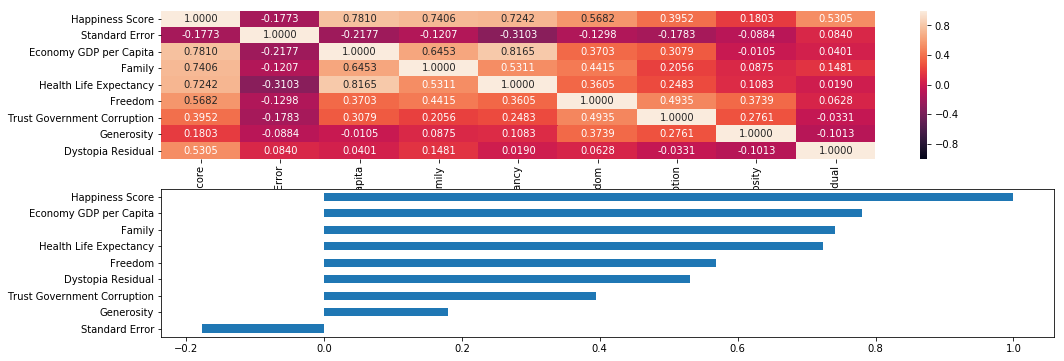

In [19]:
df2015_features = df2015.drop(['Happiness Rank'], axis=1)
f, ax = plt.subplots(2,1)
sb.heatmap(df2015_features.corr(), vmin = -1, vmax=1, annot=True, fmt='.4f', ax = ax[0])
df2015_features.corr().iloc[0,].sort_values().plot.barh(figsize=(16,6), ax=ax[1])

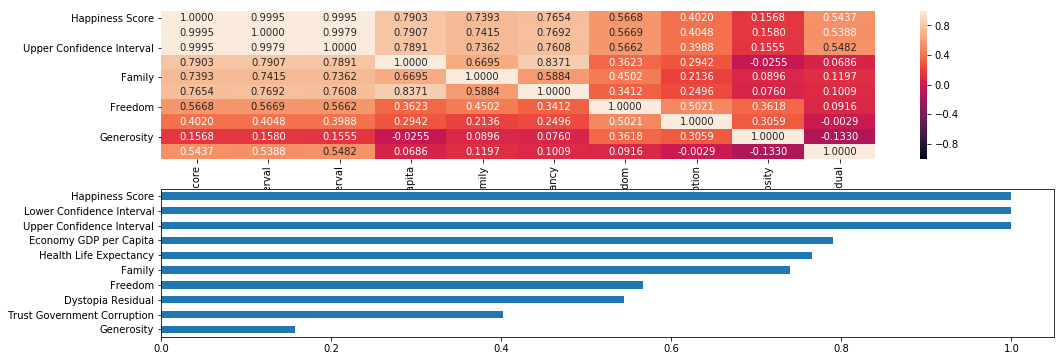

In [20]:
df2016_features = df2016.drop(['Happiness Rank'], axis=1)
f, ax = plt.subplots(2,1)
sb.heatmap(df2016_features.corr(), vmin = -1, vmax=1, annot=True, fmt='.4f', ax = ax[0])
df2016_features.corr().iloc[0,].sort_values().plot.barh(figsize=(16,6), ax=ax[1])

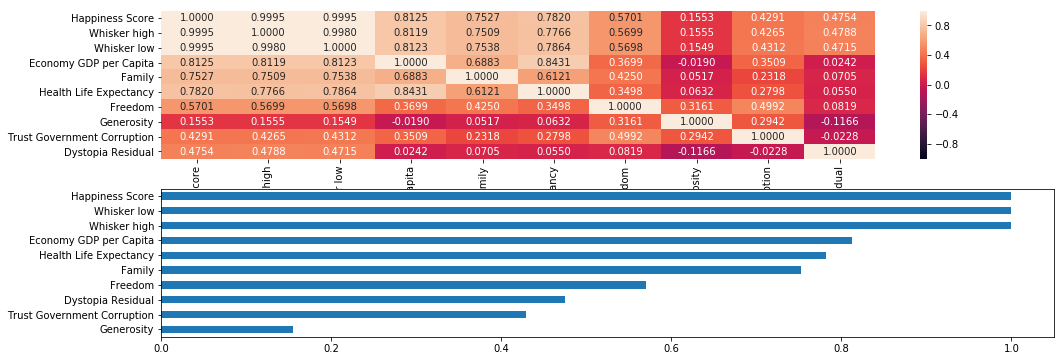

In [21]:
df2017_features = df2017.drop(['Happiness Rank'], axis=1)
f, ax = plt.subplots(2,1, figsize=(16,16))
sb.heatmap(df2017_features.corr(), vmin = -1, vmax=1, annot=True, fmt='.4f', ax = ax[0])
df2017_features.corr().iloc[0,].sort_values().plot.barh(figsize=(16,6), ax=ax[1])

In [22]:
x2017_train = df2017[['Economy GDP per Capita', 'Health Life Expectancy', 'Family']]
y2017_train = df2017['Happiness Score']
ridge.fit(x2017_train, y2017_train)
print('Training set R^2:', ridge.score(x2017_train, y2017_train))
print('Test set R^2:', ridge.score(X_test, y_test))

Training set R^2: 0.7545802681384655
Test set R^2: 0.6912651115514228


In [23]:
def welcome():
    print("*"*50)
    print("{:*^50}".format(" Welcome to Happiness Program "))
    print("{:*^50}".format("{:^30}".format("CZ1015 - Intro to")))
    print("{:*^50}".format("{:^40}".format("Data Science &")))
    print("{:*^50}".format("{:^40}".format("Artificial Intelligence")))
    print("{:*^50}".format("{:^40}".format("Gupta Jay")))
    print("{:*^50}".format("{:^40}".format("Tieu Phat Dat")))
    print("{:*^50}".format("{:^40}".format("Nguyen Duy Khanh")))
    print("{:*^50}".format("{:^30}".format("Created in")))
    print("{:*^50}".format("{:^30}".format("April 2019")))
    print("*"*50)

In [28]:
import re
def program():
    gdp = -999
    age = -999
    fml = -999
    choice = 0
    print("We will predict happiness score based on 3 features:")
    print("Economy GDP per Capita | Health Life Expectancy | Family")
    print()
    end = False
    while not end:
        if choice == 0:
            print("Select one of the choices below:")
            print("1) Enter Economy GDP per Capita")
            print("2) Enter Health Life Expectancy")
            print("3) Enter Family score")
            print("4) Predict happiness score")
            print("5) Find the country that has the most similar features to yours")
            print("6) Exit program")
            input1 = input("Your choice: ")
            if input1 not in ['1', '2', '3', '4', '5', '6']:
                print("Invalid choice, please type again")
                print("-"*60)
            else:
                choice = int(input1)
        
        elif choice == 1:
            input2 = input("Your Economy GDP per Capita: ")
            if re.match("(-)?\d+(\.\d+)?", input2):
                gdp = float(input2)
                choice = 0
                print("-"*60)
            else:
                print("Not proper input, please type again", input2)

        elif choice == 2:
            input2 = input("Your Health Life Expectancy: ")
            if re.match("(-)?\d+(\.\d+)?", input2):
                age = float(input2)
                choice = 0
                print("-"*60)
            else:
                print("Not proper input, please type again", input2)

        elif choice == 3:
            input2 = input("Your Family score: ")
            if re.match("(-)?\d+(\.\d+)?", input2):
                fml = float(input2)
                choice = 0
                print("-"*50)
            else:
                print("Not proper input, please type again", input2)

        elif choice == 4:
            if gdp == -999:
                print("You didn't enter Economy GDP per Capita")
                choice = 1
                continue
            if age == -999:
                print("You didn't enter Health Life Expectancy")
                choice = 2
                continue
            if fml == -999:
                print("You didn't enter Family score")
                choice = 3
                continue
            print("Return 0")
            
        elif choice == 6:
            end = True

In [ ]:
program()

We will predict happiness score based on 3 features:
Economy GDP per Capita | Health Life Expectancy | Family

Select one of the choices below:
1) Enter Economy GDP per Capita
2) Enter Health Life Expectancy
3) Enter Family score
4) Predict happiness score
5) Find the country that has the most similar features to yours
6) Exit program
Your choice: 4
You didn't enter Economy GDP per Capita
Your Economy GDP per Capita: 1
------------------------------------------------------------
Select one of the choices below:
1) Enter Economy GDP per Capita
2) Enter Health Life Expectancy
3) Enter Family score
4) Predict happiness score
5) Find the country that has the most similar features to yours
6) Exit program


In [ ]:
welcome()